# Cross Refering LiDAR

In [33]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.merge import merge
from rasterio.mask import mask
from shapely.geometry import box
from rasterstats import zonal_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

# --- Parameters ---
roof_dir = "output_tiffs"
ground_dir = "output_tiffs"
building_fp = "/Users/gabeiras3j/01_year_2/01_Data/21_Microsoft_buildings/example_building_footprints_Paris.geojson"
global_raster_path = "/Users/gabeiras3j/Desktop/Jacobo/00_PhD/01_year_2/01_Data/02_WUDAPT/00_Global/lambda_b_v3_2d_correct_account.tiff"
output_raster_path = "lambda_b_updated_Paris_lidar.tif"
invalid_height_value = -9999

# --- Step 1: Merge roof and ground rasters ---
def merge_tiles(tile_dir, keyword):
    files = [os.path.join(tile_dir, f) for f in os.listdir(tile_dir) if keyword in f and f.endswith('.tif')]
    srcs = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans})
    for src in srcs:
        src.close()
    return mosaic[0], meta

print("Merging roof and ground tiles...")
roof, meta = merge_tiles(roof_dir, "_roofs")
ground, _ = merge_tiles(ground_dir, "_ground")



Merging roof and ground tiles...


In [ ]:
# # --- Step 2: Compute height raster ---
# print("Calculating height raster...")
# height_raster = roof - ground
# height_raster[(roof == 0) | (ground == 0)] = np.nan  # filter invalids

In [35]:
# --- Step 3: Assign height to building footprints ---
print("Assigning heights to building footprints...")
buildings = gpd.read_file(building_fp)
buildings = buildings.to_crs(meta["crs"])  # ensure CRS match

Assigning heights to building footprints...


In [ ]:
# zs = zonal_stats(buildings, height_raster, affine=meta["transform"], stats="mean", nodata=np.nan)
# buildings["height"] = [z["mean"] if z["mean"] is not None else invalid_height_value for z in zs]

In [36]:
# run this is need heights for testing
buildings['heightMS'] = [float(buildings['properties'][i][12:15]) for i in buildings.index]

In [37]:
# Filter buildings with valid heights
valid_buildings = buildings[buildings["heightMS"] != invalid_height_value].copy()

# --- Step 4: Load global raster and crop to AOI ---
print("Cropping global raster to area of interest...")
with rasterio.open(global_raster_path) as src:
    global_crs = src.crs
    global_transform = src.transform
    global_meta = src.meta.copy()

    # Reproject buildings to global raster CRS
    valid_buildings = valid_buildings.to_crs(global_crs)

    # Get bounding box of valid buildings and crop raster
    bbox = valid_buildings.total_bounds
    window_geom = box(*bbox)
    geo = gpd.GeoDataFrame({'geometry': [window_geom]}, crs=global_crs)
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw",
        "tiled": True,
        "dtype": "float32"
    })
    global_array = out_image[0]



Cropping global raster to area of interest...


In [44]:
# Keep grid in its original CRS from global raster
grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs  # do NOT change this
)

# Auto-detect projected CRS for accurate area/length calculations
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone_number = int((lon + 180) / 6) + 1
    epsg_code = 32600 + zone_number if lat >= 0 else 32700 + zone_number
    return f"EPSG:{epsg_code}"

# Reproject buildings to projected CRS for area calculations
projected_crs = get_utm_crs(valid_buildings)
valid_buildings_proj = valid_buildings.to_crs(projected_crs)
grid_proj = grid_gdf.to_crs(projected_crs)

# Intersect in projected space (clipped shapes per grid cell)
intersection = gpd.overlay(valid_buildings_proj, grid_proj, how="intersection")


In [46]:
cell_area = 6596.8

In [47]:
# Compute roof + wall areas (in meters²)
intersection["roof_area"] = intersection.geometry.area
intersection["perimeter"] = intersection.geometry.length
intersection["wall_area"] = intersection["perimeter"] * intersection["heightMS"]
intersection["lambda_b"] = (intersection["wall_area"] + intersection["roof_area"]) / cell_area

# Group by original row/col
lambda_b_by_cell = (
    intersection.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

# 🔁 Write values back to your unchanged grid array
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

Saving updated raster to lambda_b_updated_Paris_lidar.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


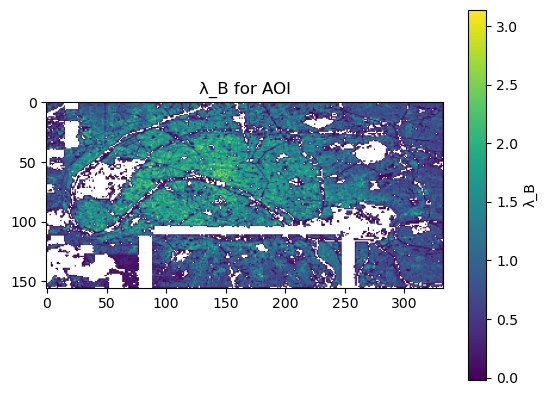

In [48]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")
with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis')
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


In [39]:
# Compute roof + wall areas (in meters²)
intersection["roof_area"] = intersection.geometry.area
intersection["perimeter"] = intersection.geometry.length
intersection["wall_area"] = intersection["perimeter"] * intersection["heightMS"]
intersection["lambda_b"] = (intersection["wall_area"] + intersection["roof_area"]) / cell_area

# Group by original row/col
lambda_b_by_cell = (
    intersection.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

# 🔁 Write values back to your unchanged grid array
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

Saving updated raster to lambda_b_updated_Paris_lidar.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


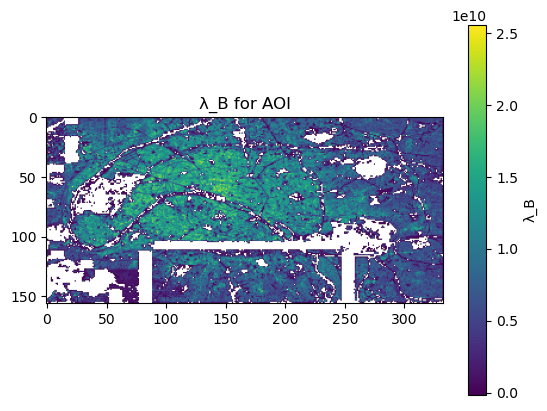

In [40]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")
with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis')
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


In [30]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.merge import merge
from rasterio.mask import mask
from shapely.geometry import box
from rasterstats import zonal_stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

# --- Parameters ---
roof_dir = "output_tiffs"
ground_dir = "output_tiffs"
building_fp = "/Users/gabeiras3j/01_year_2/01_Data/21_Microsoft_buildings/example_building_footprints_Paris.geojson"
global_raster_path = "/Users/gabeiras3j/Desktop/Jacobo/00_PhD/01_year_2/01_Data/02_WUDAPT/00_Global/lambda_b_v3_2d_correct_account.tiff"
output_raster_path = "lambda_b_updated_Paris_lidar.tif"
invalid_height_value = -9999

# --- Step 1: Merge roof and ground rasters ---
def merge_tiles(tile_dir, keyword):
    files = [os.path.join(tile_dir, f) for f in os.listdir(tile_dir) if keyword in f and f.endswith('.tif')]
    srcs = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(srcs)
    meta = srcs[].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans})
    for src in srcs:
        src.close()
    return mosaic[0], meta

print("Merging roof and ground tiles...")
roof, meta = merge_tiles(roof_dir, "_roofs")
ground, _ = merge_tiles(ground_dir, "_ground")

SyntaxError: invalid syntax (582463573.py, line 26)

In [11]:
# --- Step 2: Compute height raster ---
print("Calculating height raster...")
height_raster = roof - ground
height_raster[(roof == 0) | (ground == 0)] = np.nan  # filter invalids

Calculating height raster...


ValueError: operands could not be broadcast together with shapes (3201,4201) (534,701) 

In [4]:
# --- Step 3: Assign height to building footprints ---
print("Assigning heights to building footprints...")
buildings = gpd.read_file(building_fp)
buildings = buildings.to_crs(meta["crs"])  # ensure CRS match

Assigning heights to building footprints...


In [12]:
zs = zonal_stats(buildings, height_raster, affine=meta["transform"], stats="mean", nodata=np.nan)
buildings["height"] = [z["mean"] if z["mean"] is not None else invalid_height_value for z in zs]

NameError: name 'height_raster' is not defined

In [ ]:
# run this is need heights for testing
buildings['heightMS'] = [float(buildings['properties'][i][12:15]) for i in buildings.index]

In [15]:
# Filter buildings with valid heights
valid_buildings = buildings[buildings["heightMS"] != invalid_height_value].copy()

In [16]:
# --- Step 4: Load global raster and crop to AOI ---
print("Cropping global raster to area of interest...")
with rasterio.open(global_raster_path) as src:
    global_crs = src.crs
    global_transform = src.transform
    global_meta = src.meta.copy()

    # Reproject buildings to global raster CRS
    valid_buildings = valid_buildings.to_crs(global_crs)

    # Get bounding box of valid buildings and crop raster
    bbox = valid_buildings.total_bounds
    window_geom = box(*bbox)
    geo = gpd.GeoDataFrame({'geometry': [window_geom]}, crs=global_crs)
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw",
        "tiled": True,
        "dtype": "float32"
    })
    global_array = out_image[0]



Cropping global raster to area of interest...


In [17]:
# --- Step 5: Calculate lambda_b per grid cell in AOI ---
print("Calculating lambda_b values...")
res_x = abs(out_transform[0])
res_y = abs(out_transform[4])
cell_area = res_x * res_y
updated = np.full(global_array.shape, invalid_height_value, dtype=np.float32)

Calculating lambda_b values...


In [25]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
from shapely.geometry import Polygon

print("Vectorizing grid and calculating lambda_b...")

# Step 5a: Generate grid as GeoDataFrame
grid_polys = []
rows, cols = updated.shape
for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
        grid_polys.append((row, col, poly))

grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs
)

# Step 5b: Spatial join (assign buildings to grid cells)
joined = gpd.sjoin(valid_buildings, grid_gdf, how="inner", predicate="intersects")

# Step 5c: Compute λ_B for each grid cell
joined["inter_area"] = joined.geometry.area
joined["wall_area"] = joined["inter_area"] * joined["heightMS"]
joined["roof_area"] = joined["inter_area"]

lambda_b_by_cell = (
    joined.groupby(["row", "col"])
    .agg({"wall_area": "sum", "roof_area": "sum"})
    .reset_index()
)

lambda_b_by_cell["lambda_b"] = (lambda_b_by_cell["wall_area"] + lambda_b_by_cell["roof_area"]) / cell_area

# Step 5d: Write values into raster array
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]


Vectorizing grid and calculating lambda_b...


Saving updated raster to lambda_b_updated_Paris_lidar.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


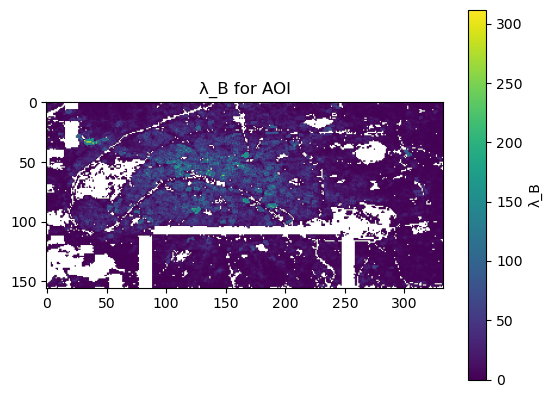

In [32]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")

with rasterio.open(output_raster_path + '2nd', "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis')
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


In [27]:
rows, cols = updated.shape
for row in range(rows):
    print(row)
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        cell_geom = box(x - res_x/2, y - res_y/2, x + res_x/2, y + res_y/2)
        cell_gdf = gpd.GeoDataFrame(geometry=[cell_geom], crs=global_crs)
        intersection = gpd.overlay(valid_buildings, cell_gdf, how='intersection')

        if not intersection.empty:
            intersection["area"] = intersection.geometry.area
            intersection["wall_area"] = intersection["area"] * intersection["heightMS"]
            intersection["roof_area"] = intersection["area"]
            lambda_b = (intersection["wall_area"].sum() + intersection["roof_area"].sum()) / cell_area
            updated[row, col] = lambda_b


0


KeyboardInterrupt: 

In [ ]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")
with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis')
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()